In [18]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
import random
from typing import Tuple
import seaborn as sns

In [2]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# ----------------------------- Read and Shuffle Word List -----------------------------
# Reads a list of words from a file, strips whitespace from each word,
# and shuffles the list to randomize the order of words.

with open(f"./names.txt") as file:
    words = file.readlines()
# print(words)
words = [word.strip() for word in words]
# Shuffle for training splits, inplace
random.shuffle(words)
    

In [4]:
# ----------------------------- Build Token-to-Integer Mapping -----------------------------
# Constructs a mapping between each unique character in the words dataset to its corresponding integer index,
# including special start ('<S>') and end ('<E>') tokens. This ensures each character is represented numerically.

# Store alphabet from data
alphabet = set()

# For every character of each word
for word in words:
    for char in word:
        alphabet.add(char)
        
# Add start and end tokens
alphabet.add('<S>')
alphabet.add('<E>')
alphabet = sorted(alphabet)

# Store numeric conversions of tokens
tok_to_int = dict()
int_to_tok = dict()

# Iterate across entire alphabet
for i, token in enumerate(alphabet):
    tok_to_int[token] = i
    int_to_tok[i] = token

In [5]:
# ----------------------------- Prepare Training, Validation, and Test Data -----------------------------
# Constructs training sequences (X) and their corresponding targets (Y) from words dataset,
# with each sequence padded with start ("<S>") and end ("<E>") tokens. Splits the data into
# training, validation, and test sets for model training and evaluation.

# Define Window Size 
window_size = 3

# Store training vardiables
X = []
Y = []

#Iterate over each word
for word in words:

    # Store initial window of padding
    window = [tok_to_int["<S>"] for _ in range(window_size)]
    # Add ending token to word
    word = list(word) + ['<E>']

    # Store edge case training point
    X.append(window) 
    # Store edge case target
    Y.append(tok_to_int[word[0]]) #T
    # Iterate over each character + padding
    for char1, char2 in zip(word[:], word[1:]):
        # Store training data and targets
        # print(window)
        window = window[1:] + [tok_to_int[char1]]
        # Store window in training set
        X.append(window)
        # print(tok_to_int[char2])
        Y.append(tok_to_int[char2])

train_idx = int(.8 * len(X))
val_idx = int(.9 * len(X))


X_train = torch.tensor(X[0:train_idx]).to(device)
Y_train = torch.tensor(Y[0:train_idx]).to(device)
X_val  = torch.tensor(X[train_idx:val_idx]).to(device)
Y_val = torch.tensor(Y[train_idx:val_idx]).to(device)
X_test = torch.tensor(X[val_idx:]).to(device)
Y_test = torch.tensor(Y[val_idx:]).to(device)

In [6]:
# ----------------------------- Define Neural Network Parameters -----------------------------
# Defines the parameters for a neural network including embedding matrix (C), weights (W1, W2),
# biases (B1, B2), and parameters for batch normalization (batch_scale, batch_shift).
# Initializes these parameters with random values and applies Xavier/Glorot initialization to weights.

# Define variables
len_of_emb = 10
neurons_in_first_layer = 300

# Second layer = final layer
neurons_in_second_layer = 28

# Create parameters as leaf tensors: REMOVED BIAS in favor of Batch Normalization
C = torch.rand(len(alphabet), len_of_emb, requires_grad=True, device=device, dtype=torch.float64)
W1 = torch.empty(window_size * len_of_emb, neurons_in_first_layer, requires_grad=True, device=device, dtype=torch.float64)
# B1 = torch.zeros(neurons_in_first_layer, requires_grad=True, device=device, dtype=torch.float64) 
W2 = torch.empty(neurons_in_first_layer, neurons_in_second_layer, requires_grad=True, device=device, dtype=torch.float64)
# B2 = torch.zeros(neurons_in_second_layer, requires_grad=True, device=device, dtype=torch.float64) 

# Store scale and shift parameters for batch normalization, initialized for no transofmration
batch_scale_l1 = torch.ones(1, neurons_in_first_layer, requires_grad=True, device=device, dtype=torch.float64) 
batch_shift_l1 = torch.zeros(1, neurons_in_first_layer, requires_grad=True, device=device, dtype=torch.float64) 
batch_scale_l2 = torch.ones(1, neurons_in_second_layer, requires_grad=True, device=device, dtype=torch.float64) 
batch_shift_l2 = torch.zeros(1, neurons_in_second_layer, requires_grad=True, device=device, dtype=torch.float64) 


# Avoids recalculating batch normalization statistics for the validation set
# by maintaining a running count of mean and standard deviation during training.
running_mean_l1 = torch.zeros(1, neurons_in_first_layer, requires_grad=False, device=device, dtype=torch.float64) 
running_std_l1 = torch.ones(1, neurons_in_first_layer, requires_grad=False, device=device, dtype=torch.float64) 
running_mean_l2 = torch.zeros(1, neurons_in_second_layer, requires_grad=False, device=device, dtype=torch.float64) 
running_std_l2 = torch.ones(1, neurons_in_second_layer, requires_grad=False, device=device, dtype=torch.float64) 


# Xavier/Glorot Initialization for weights
torch.nn.init.xavier_uniform_(W1)
torch.nn.init.xavier_uniform_(W2)

# print(C.is_leaf, W1.is_leaf, W2.is_leaf, B1.is_leaf, B2.is_leaf)
# add val and test embeddings
val_emb = C[X_val].view(-1, window_size*len_of_emb).to(torch.float64)
test_emb= C[X_test].view(-1, window_size*len_of_emb).to(torch.float64)

parameters = [C, W1, W2, batch_scale_l1, batch_shift_l1, batch_scale_l2, batch_shift_l2]

# Check dimensions
# print(embed.T.shape, W1.shape, B1.shape)
# print(embed.T.shape, W2.shape, B2.shape)

# # Optimization data : Smith's Method - Find lr comparing Low to high learning rates, selecting @ elbow point
# lr_line = torch.linspace(-3, 0, num_of_iters) # for choosing optimal lr
# lr_exp = 10 ** lr_line #this transformations yields values between .001 and 1


In [7]:
# ----------------------------- Optimization Data and Helper Functions -----------------------------


@torch.no_grad()
def update_batch_stats(input_mean: torch.Tensor, input_std: torch.Tensor, running_mean: torch.Tensor, running_std: torch.Tensor) -> None:
    running_mean.mul_(0.999).add_(input_mean * 0.001)
    running_std.mul_(0.999).add_(input_std * 0.001)

def batch_normalization(input_batch: torch.Tensor, batch_scale: torch.Tensor, batch_shift: torch.Tensor, running_mean: torch.Tensor, running_std: torch.Tensor, eval: bool = False) -> torch.Tensor:
    if not eval:
        input_mean, input_std = torch.mean(input_batch, dim=0, keepdim=True), torch.std(input_batch, dim=0, keepdim=True)
        update_batch_stats(input_mean, input_std, running_mean, running_std)
        norm_batch = (input_batch - input_mean) / (input_std + 1e-5)
    else:
        norm_batch = (input_batch - running_mean) / (running_std + 1e-5)
    
    return batch_scale * norm_batch + batch_shift

def mini_batch(size: int = 64) -> Tuple[torch.Tensor, torch.Tensor]:
    indices = torch.randint(0, X_train.shape[0], (size,), device=device)
    batch_X = X_train[indices]
    batch_input_emb = C[batch_X].view(-1, window_size * len_of_emb).to(torch.float64)
    return batch_input_emb, Y_train[indices]

def forward_pass(inputs: torch.Tensor, eval: bool = False) -> torch.Tensor:
    if not eval:
        pre_act = inputs @ W1
        norm_batch = batch_normalization(pre_act, batch_scale_l1, batch_shift_l1, running_mean_l1, running_std_l1)
        first_activation = F.tanh(norm_batch)
        logits = first_activation @ W2
        result = batch_normalization(logits, batch_scale_l2, batch_shift_l2, running_mean_l2, running_std_l2)
    else:
        with torch.no_grad():
            pre_act = inputs @ W1
            norm_batch = batch_normalization(pre_act, batch_scale_l1, batch_shift_l1, running_mean_l1, running_std_l1, eval=True)
            first_activation = F.tanh(norm_batch)
            logits = first_activation @ W2
            result = batch_normalization(logits, batch_scale_l2, batch_shift_l2, running_mean_l2, running_std_l2, eval=True)
    return result

# Training parameters
num_of_iters = 1000
best_val_score = float('inf')
batch_size = 64
lr = 1e-3
patience = 1000
strikes = 0

In [8]:
# ----------------------------- Training Loop -----------------------------
import torch
import torch.nn.functional as F

train_loss_stats = []
val_loss_stats = []
update_to_data = []

# Training loop
for step in range(num_of_iters):
    # ----------------------------- Get mini batch -----------------------------
    training_data, targets = mini_batch(batch_size)
    
    # Ensure data is on the correct device (not necessary if mini_batch already does this)
    training_data = training_data.to(device)
    targets = targets.to(device)
    
    # ----------------------------- Zero out gradients -----------------------------
    for p in parameters:
        if p.grad is not None:
            p.grad.zero_()

    # ----------------------------- Forward pass -----------------------------
    logits = forward_pass(training_data)
    
    # ----------------------------- Calculate Loss -----------------------------
    train_loss = F.cross_entropy(logits, targets)
    
    # ----------------------------- Backpropagation -----------------------------
    train_loss.backward()

    # ----------------------------- Gradient clipping (optional) -----------------------------
    # torch.nn.utils.clip_grad_norm_(parameters, max_norm=1.0)

    # ----------------------------- Update weights -----------------------------
    with torch.no_grad():
        for param in parameters:
            if param.grad is not None:
                param.sub_(lr * param.grad)

    # ----------------------------- Validation -----------------------------
    with torch.no_grad():
        val_logits = forward_pass(val_emb, eval=True)
        val_loss = F.cross_entropy(val_logits, Y_val)
    
    # ----------------------------- Store losses -----------------------------
    train_loss_stats.append(train_loss.item())
    val_loss_stats.append(val_loss.item())
    
    # ----------------------------- Early stopping logic -----------------------------
    if val_loss < best_val_score:
        best_val_score = val_loss
        strikes = 0
    else:
        strikes += 1
        if strikes >= patience:
            print(f"Training Terminated on iteration {step}.")
            print(f" Training Loss: {train_loss:.4f}")
            print(f" Validation Loss: {val_loss:.4f}")
            break

    # ----------------------------- Output stats -----------------------------
    if step % 250 == 0:
        print(f"Number of iterations: {step}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # ----------------------------- Store update to data ratio -----------------------------
    with torch.no_grad():
        ratio = [((lr * p.grad.std() / p.data.std()).log().item() if p.grad is not None else float('nan')) for p in parameters]
        update_to_data.append(ratio)

Number of iterations: 0, Training Loss: 3.9999, Validation Loss: 3.3769
Number of iterations: 250, Training Loss: 3.3979, Validation Loss: 3.3585
Number of iterations: 500, Training Loss: 3.2512, Validation Loss: 3.3298
Number of iterations: 750, Training Loss: 3.3013, Validation Loss: 3.2947


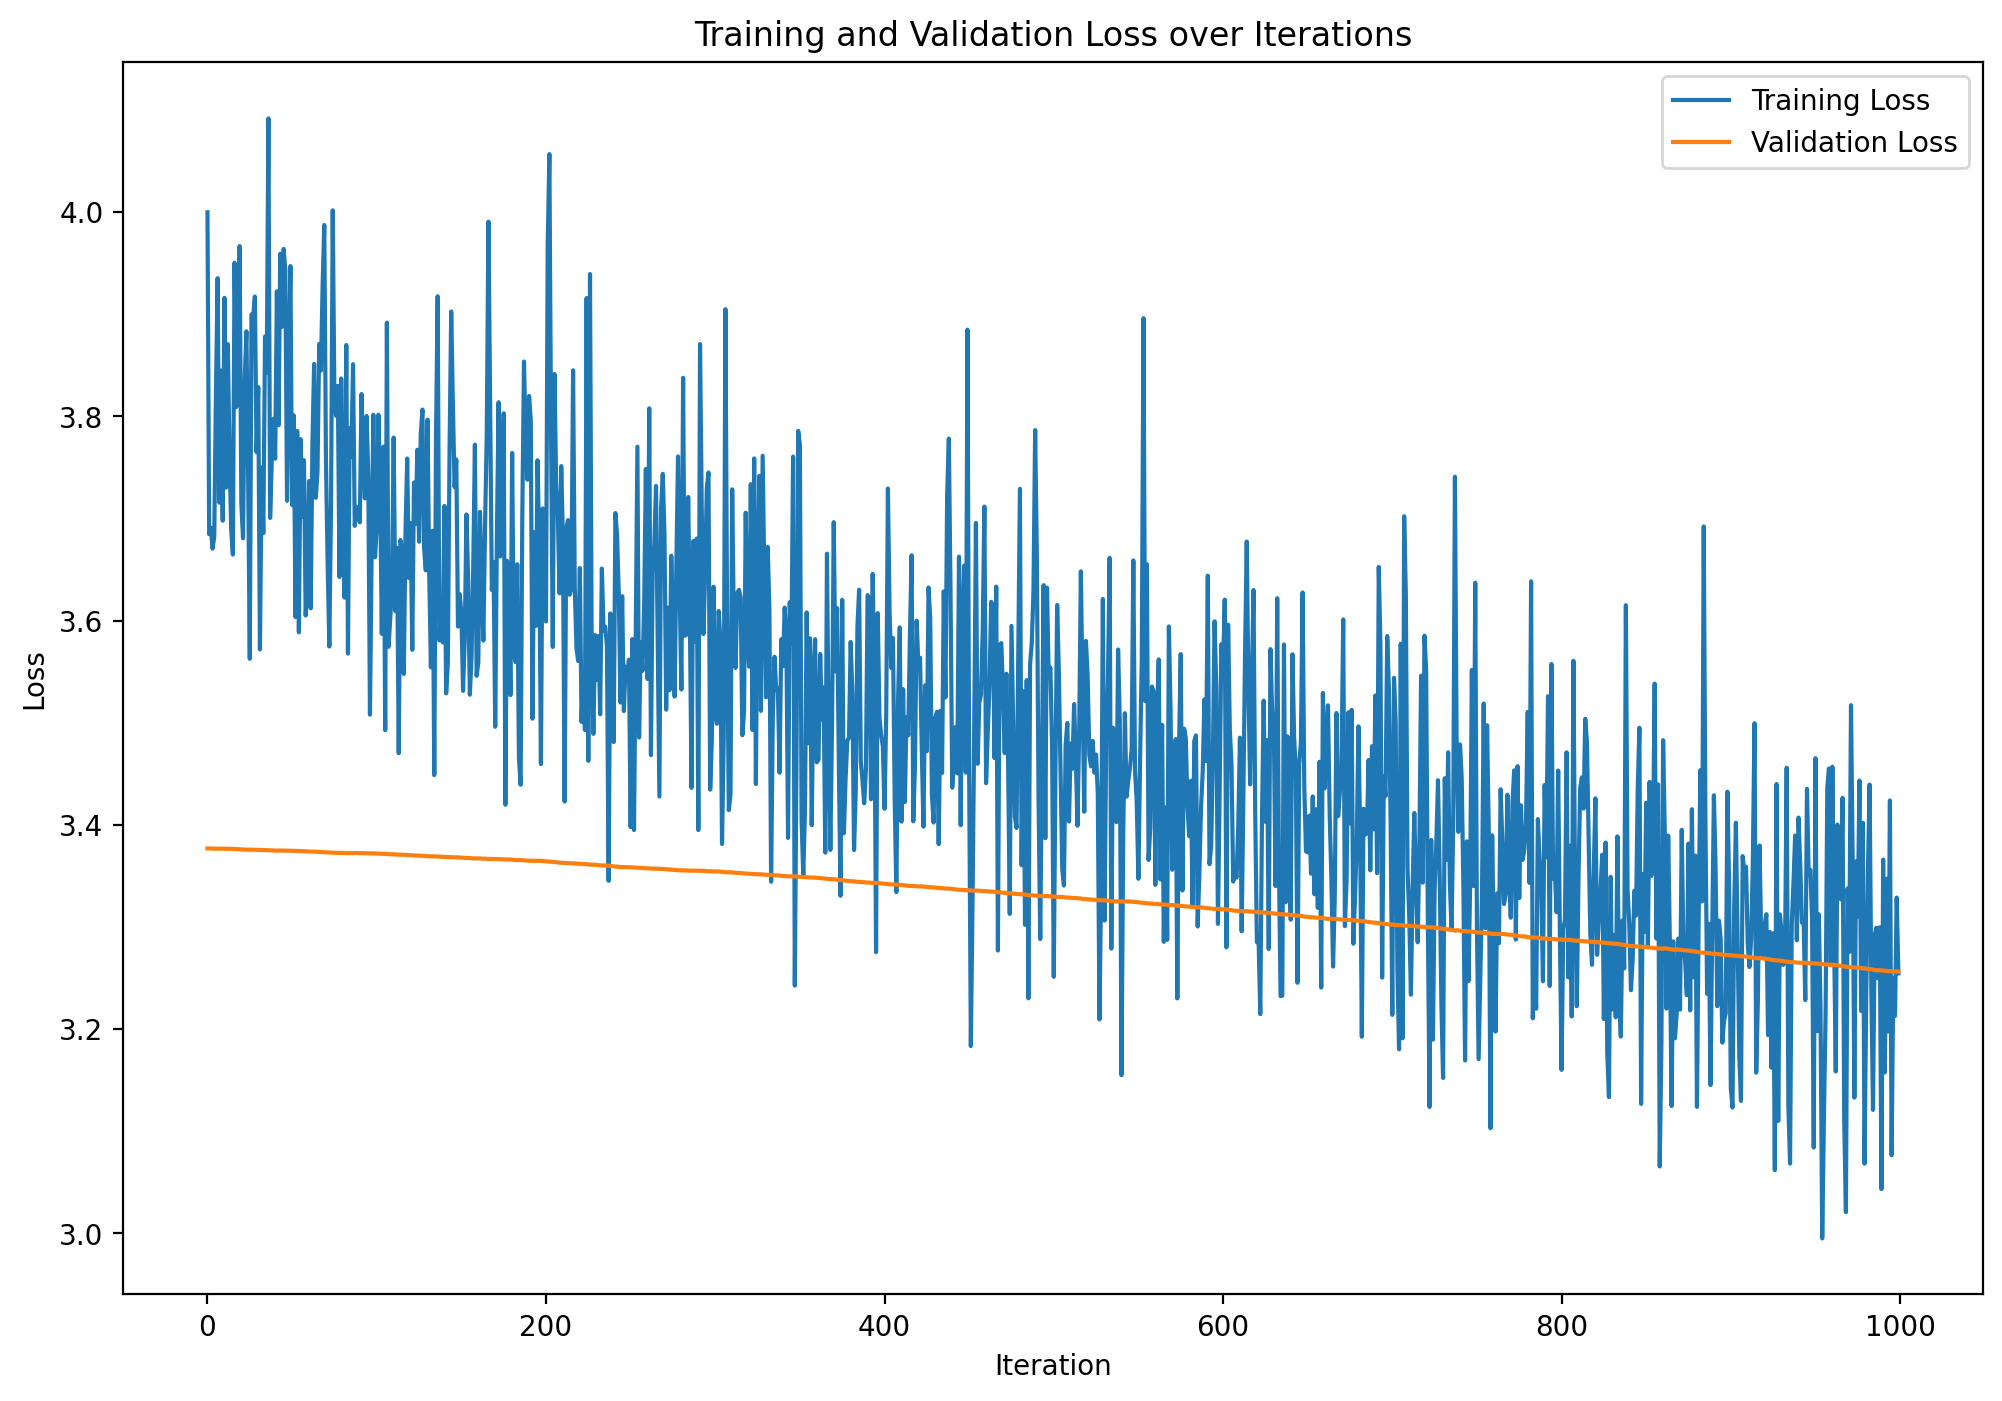

In [9]:
# ----------------------------- Plot Loss -----------------------------
# Visualizes the training and validation loss over iterations.
# Plots the training loss and validation loss on a graph to monitor model performance.

plt.figure(figsize=(12, 8), dpi=200)  
# Plot loss over steps
plt.plot(train_loss_stats, label='Training Loss')
plt.plot(val_loss_stats, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Iterations')
plt.legend()
plt.show()

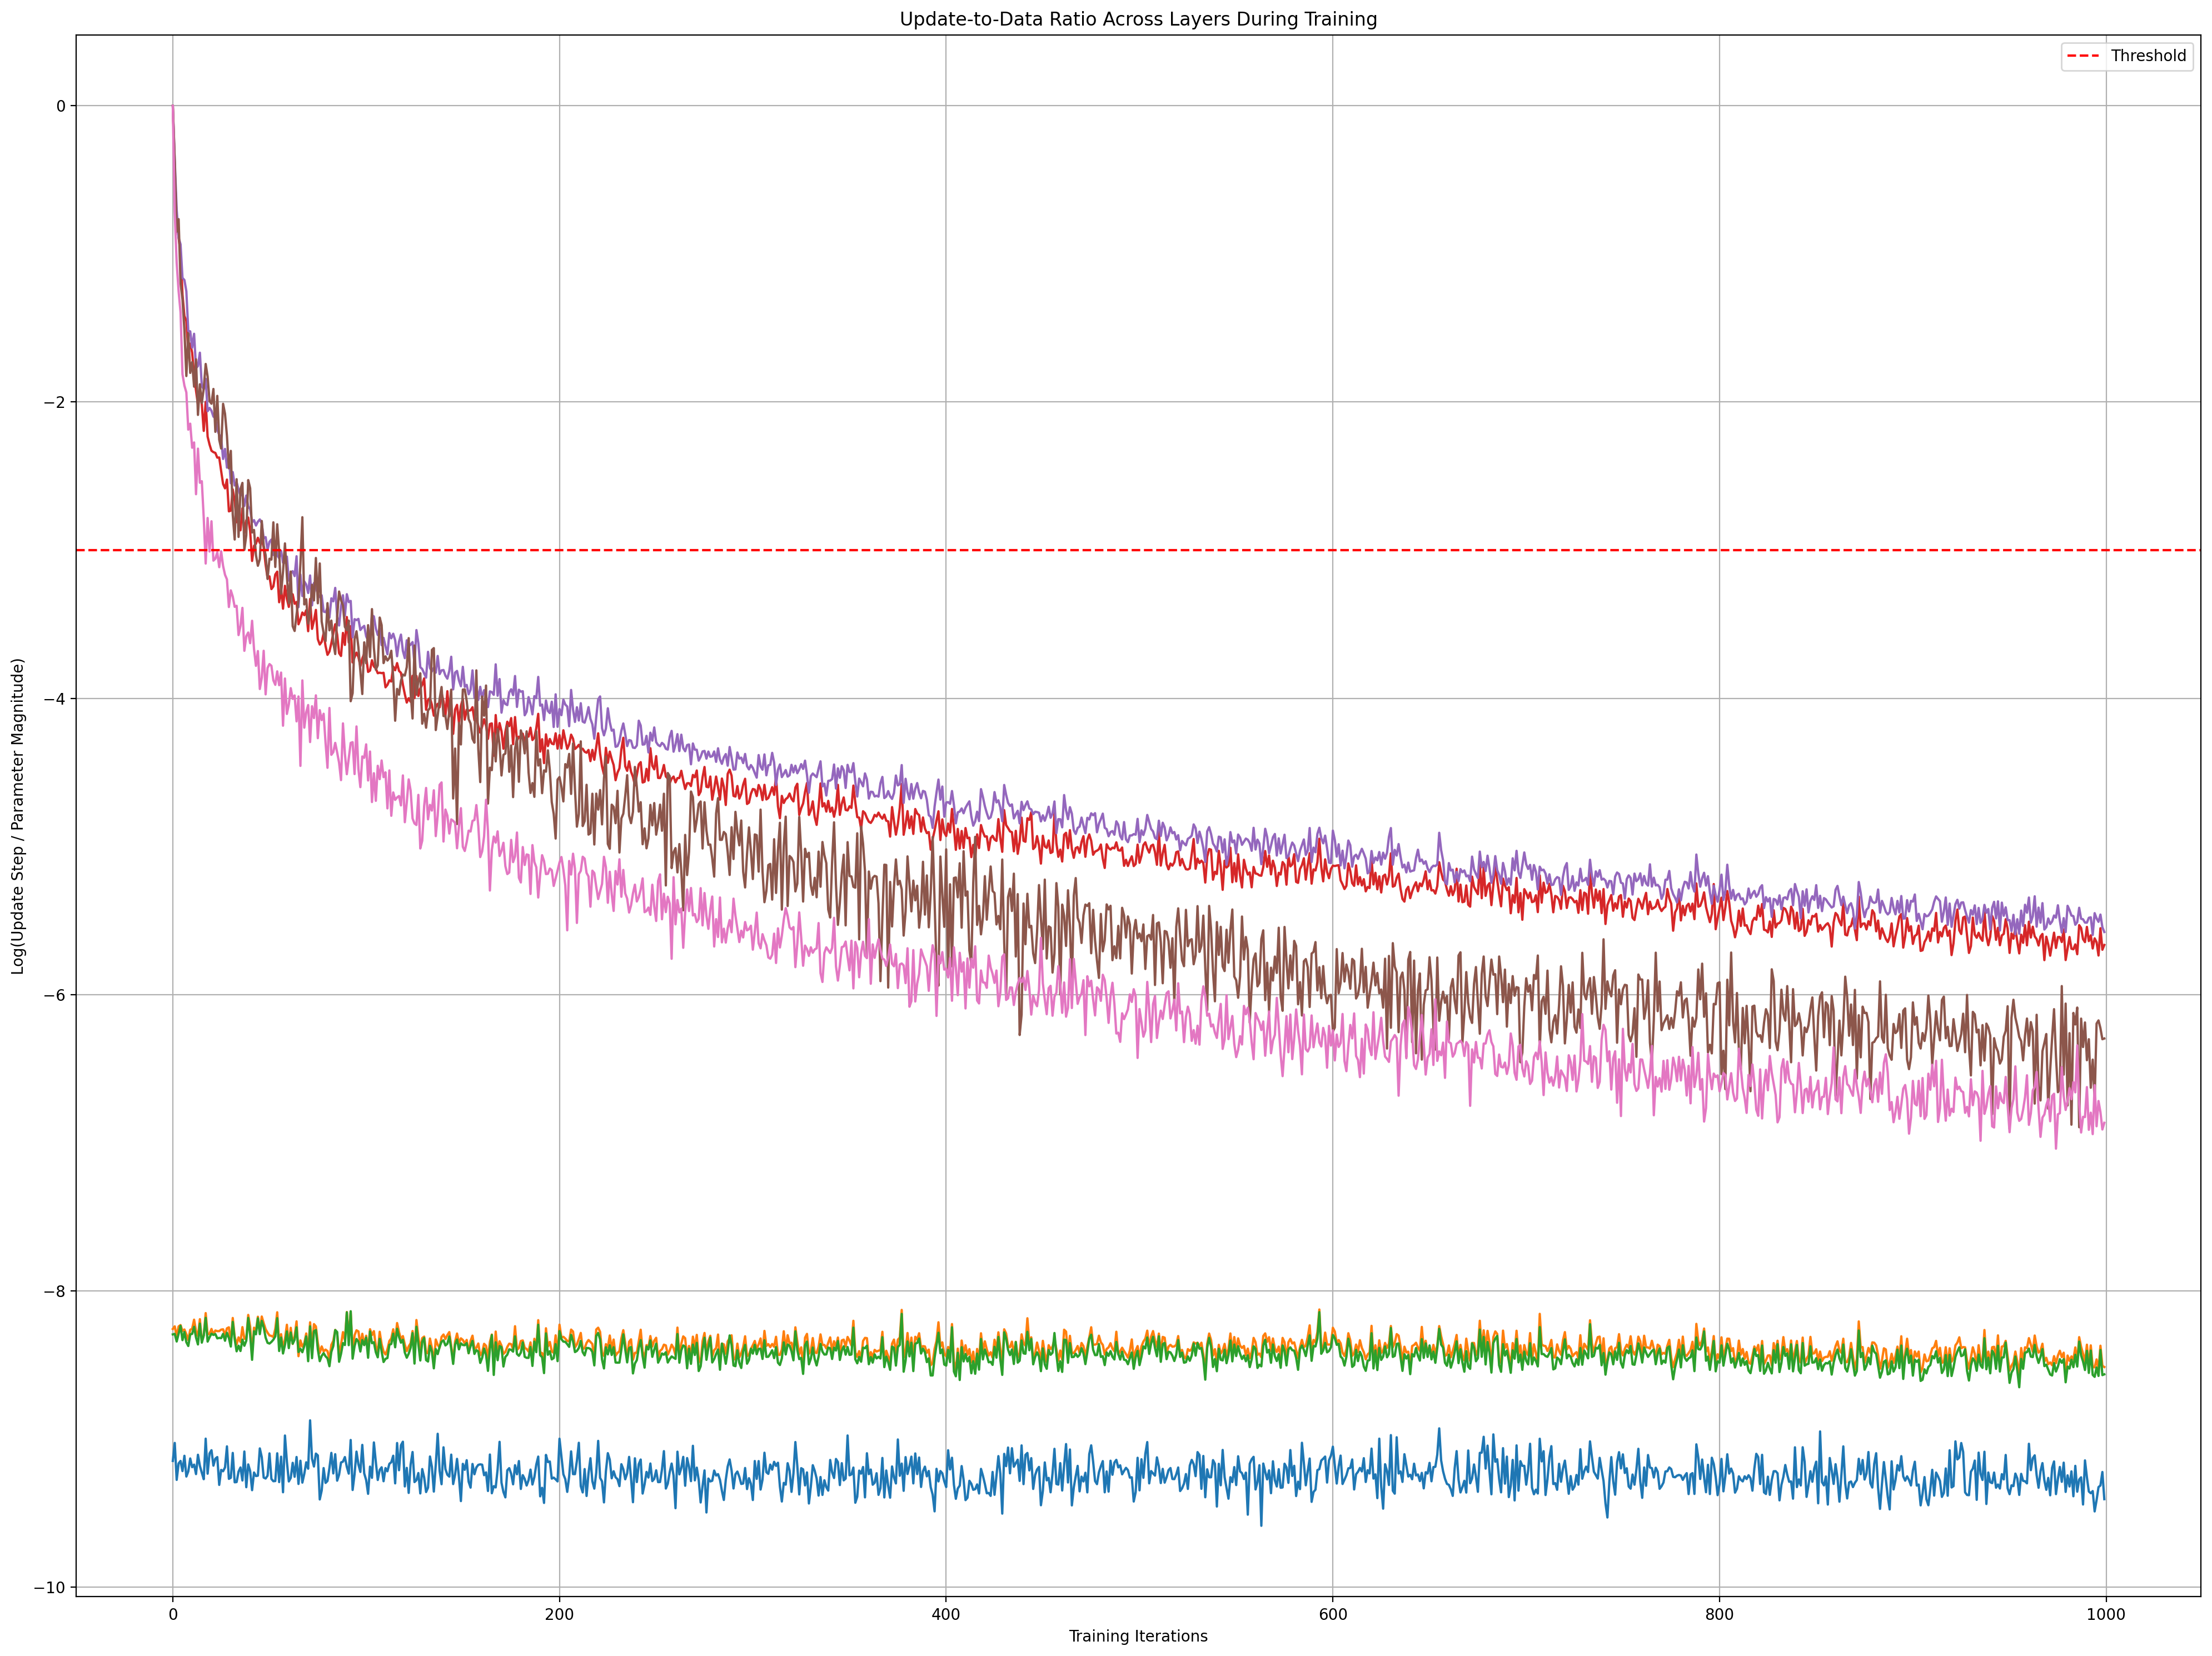

In [49]:
# shows the ratio of the update size to the size of the data 
# for each parameter in the model across different layers during training

plt.figure(figsize=(20, 15), dpi=200)
testing = torch.tensor(update_to_data, dtype = torch.float64)

for dim in range(len(parameters)):
    data = testing[:,dim]
    # print(data)
    plt.plot(data)
    
# Target line
plt.axhline(y=-3, color='r', linestyle='--', label='Threshold')
plt.title('Update-to-Data Ratio Across Layers During Training')
plt.xlabel('Training Iterations')
plt.ylabel('Log(Update Step / Parameter Magnitude)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

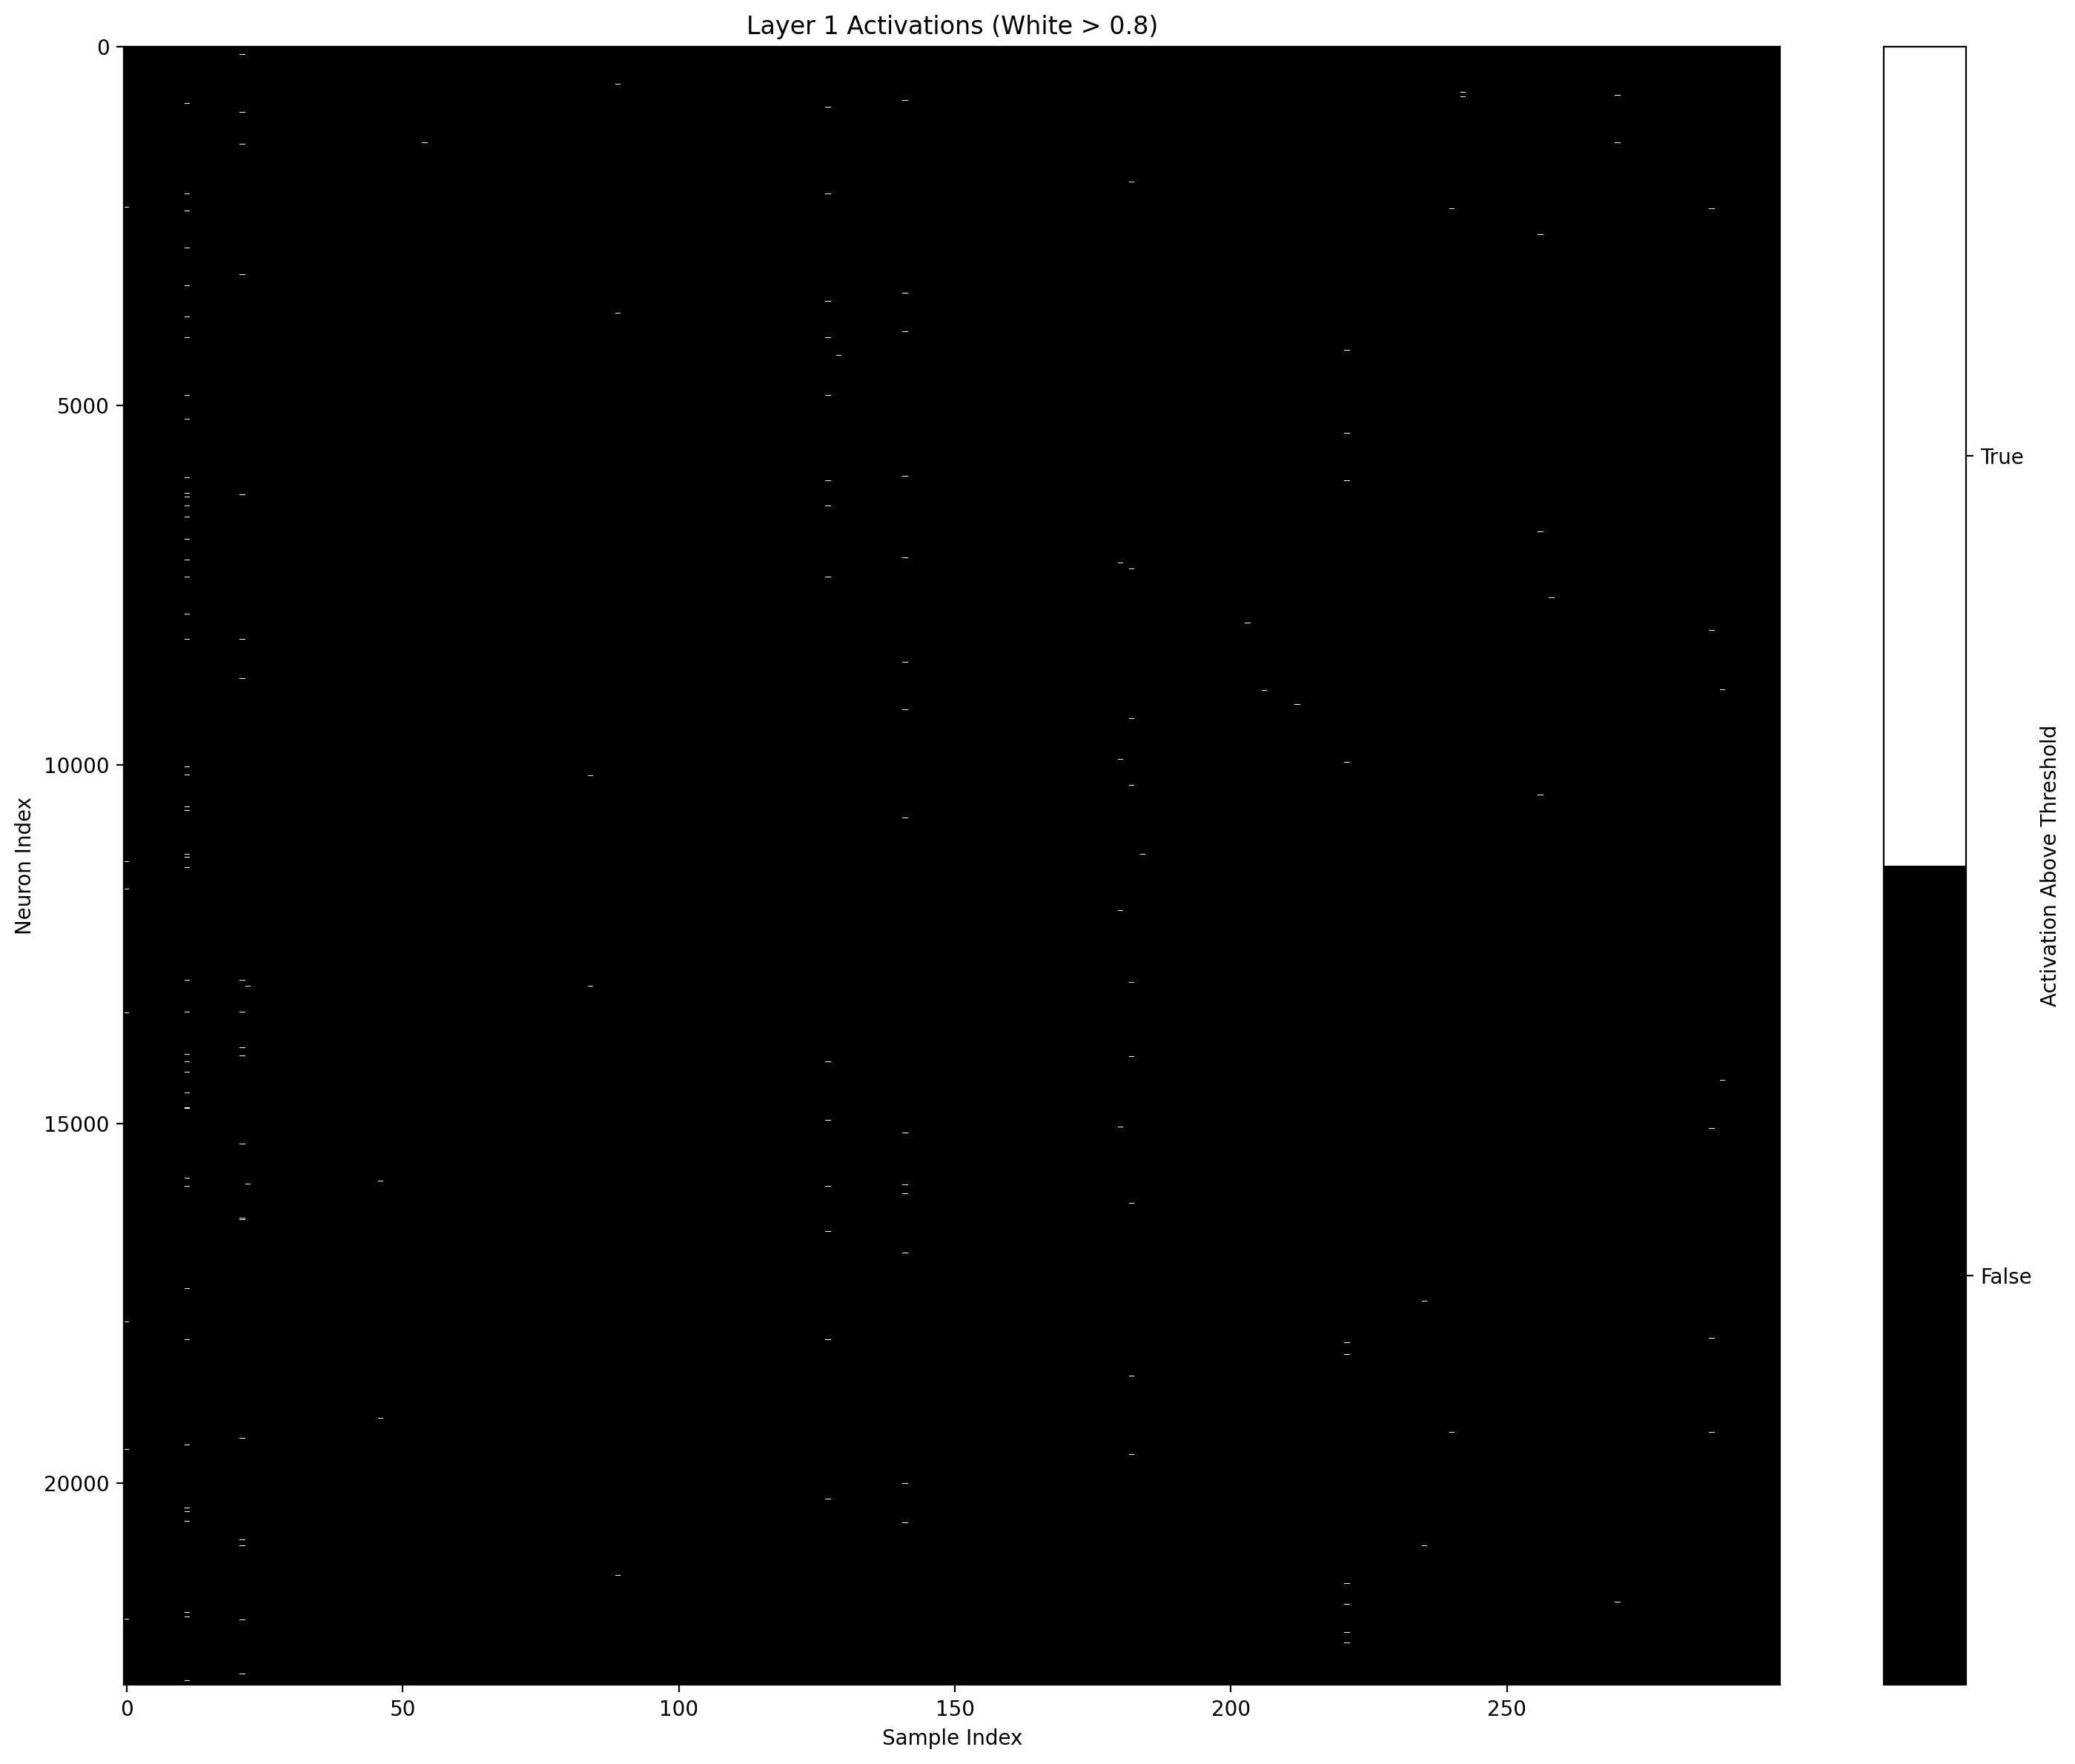

Total activations: 6844500
Activations above threshold: 1660
Percentage above threshold: 0.02%


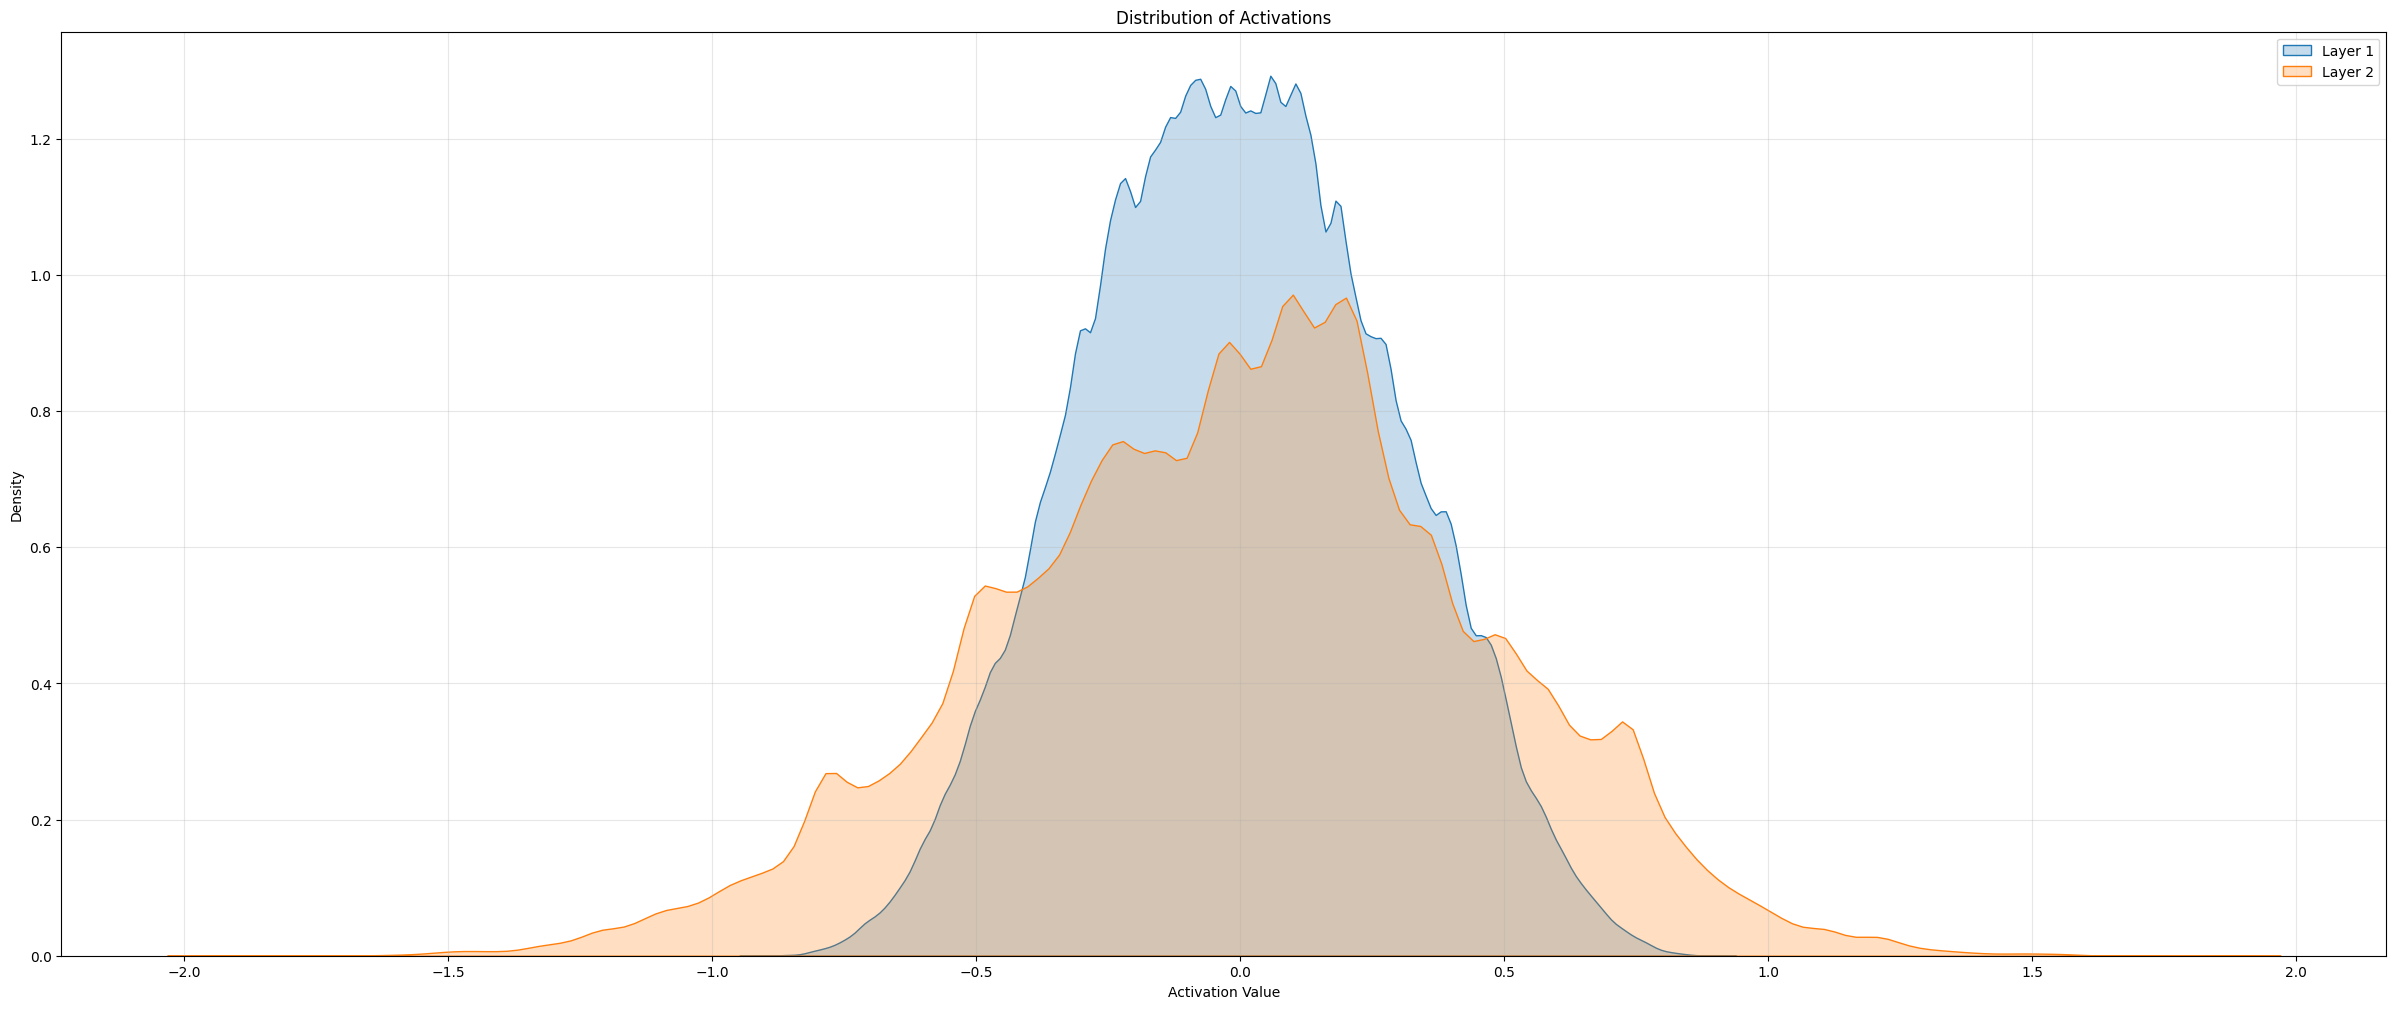

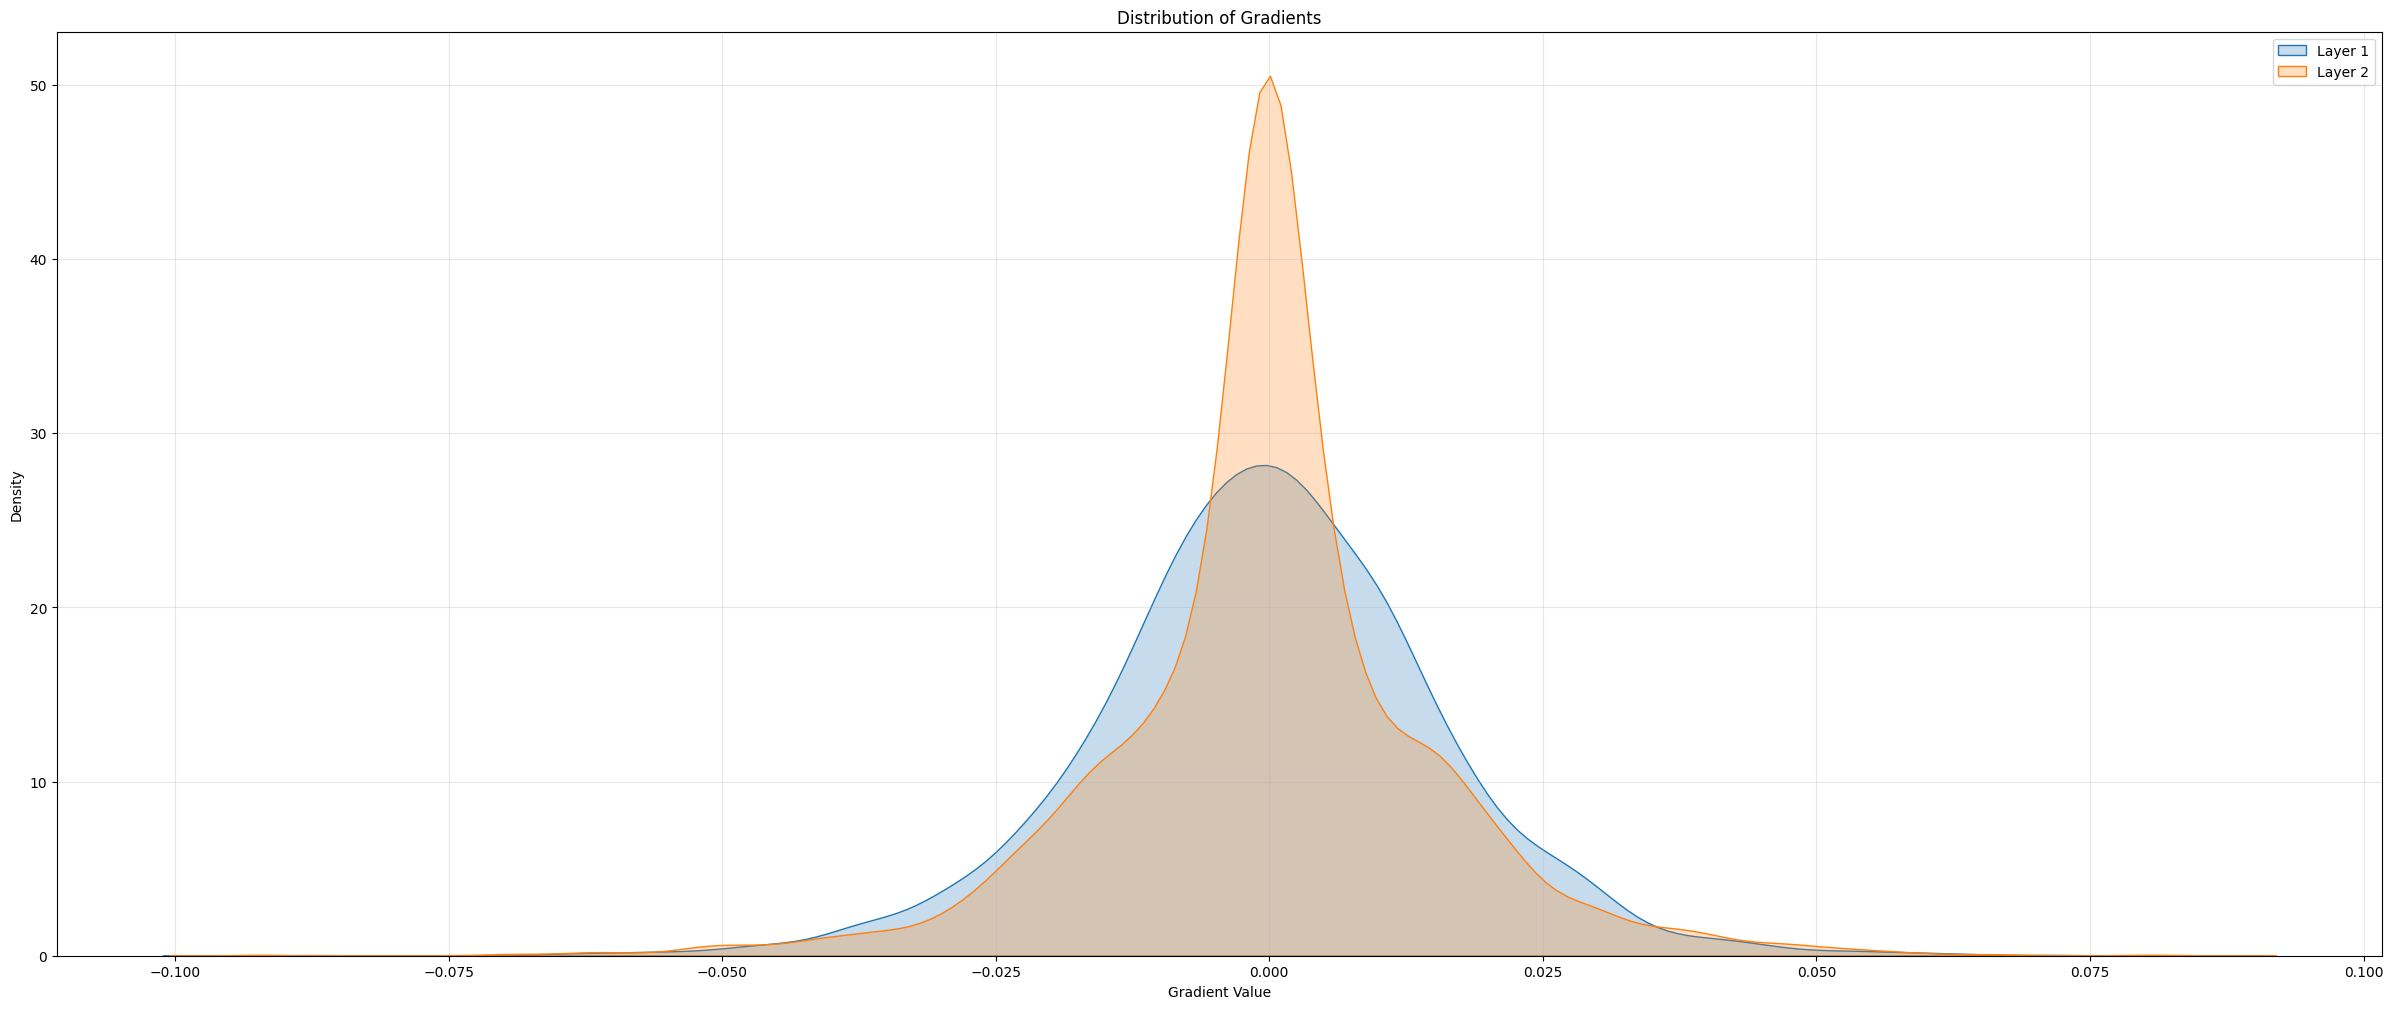

In [47]:
from matplotlib.colors import ListedColormap

def get_activations(inputs):
    with torch.no_grad():
        pre_act1 = inputs @ W1
        norm_batch1 = batch_normalization(pre_act1, batch_scale_l1, batch_shift_l1, running_mean_l1, running_std_l1, eval=True)
        activation1 = F.tanh(norm_batch1)
        pre_act2 = activation1 @ W2
        activation2 = batch_normalization(pre_act2, batch_scale_l2, batch_shift_l2, running_mean_l2, running_std_l2, eval=True)
    
    return activation1, activation2

def plot_distributions(data_list, labels, title, xlabel):
    plt.figure(figsize=(30, 12))
    for data, label in zip(data_list, labels):
        sns.kdeplot(data.cpu().numpy().flatten(), fill=True, label=label)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Get activations for validation set
with torch.no_grad():
    val_activations1, val_activations2 = get_activations(val_emb)
    

# Create a mask for activations above the threshold
threshold = 0.8
mask = val_activations1 > threshold

# Create a custom colormap
colors = ['black', 'white']
cmap = ListedColormap(colors)

# Plot the activations
fig, ax = plt.subplots(figsize=(15, 12), dpi=200)
im = ax.imshow(mask, cmap=cmap, aspect='auto', interpolation='nearest')

# Create a custom colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0.25, 0.75])
cbar.set_ticklabels(['False', 'True'])
cbar.set_label('Activation Above Threshold')

plt.title(f'Layer 1 Activations (White > {threshold})')
plt.xlabel('Sample Index')
plt.ylabel('Neuron Index')
plt.tight_layout()
plt.show()

# Print some statistics
total_activations = mask.numel()
activations_above_threshold = mask.sum().item()
percentage_above_threshold = 100 * activations_above_threshold / total_activations

print(f"Total activations: {total_activations}")
print(f"Activations above threshold: {activations_above_threshold}")
print(f"Percentage above threshold: {percentage_above_threshold:.2f}%")
# Plot activations
plot_distributions(
    [val_activations1, val_activations2],
    ['Layer 1', 'Layer 2'],
    'Distribution of Activations',
    'Activation Value'
)

# For gradients, we need to enable gradient computation temporarily
W1.requires_grad_(True)
W2.requires_grad_(True)

# Compute gradients
inputs, targets = mini_batch(batch_size)  # Get a mini-batch for gradient computation
logits = forward_pass(inputs)
loss = F.cross_entropy(logits, targets)
loss.backward()

# Plot gradients
plot_distributions(
    [W1.grad, W2.grad],
    ['Layer 1', 'Layer 2'],
    'Distribution of Gradients',
    'Gradient Value'
)

# Clear gradients
W1.grad = None
W2.grad = None